In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# %cd /content/drive/My Drive/Research Project

/content/drive/My Drive/Research Project


In [37]:
import pandas as pd
import numpy as np
import os
# import src
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
# pip install -U mittens

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from statistics import mean, stdev, median, mode
# With PCA
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import CountVectorizer
# SVM
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from mittens import GloVe, Mittens

In [40]:
# pip install autocorrect

In [41]:

import nltk
# nltk.download()
import string
from nltk.tokenize import word_tokenize
import random
import pickle
from nltk.corpus import stopwords

from autocorrect import Speller
# from pycontractions import Contractions

# from spellchecker import SpellChecker

import re
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer 

from hyperopt import fmin, tpe, hp

In [42]:
# nltk.download('all')

In [43]:
import tensorflow_addons as tfa

from numpy import asarray
from numpy import zeros
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Dropout, MaxPool1D
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Bidirectional
import tensorflow.keras.backend as K

In [44]:
# nltk.download('all')

In [45]:
# # Load your favorite word2vec model
# cont = Contractions('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz')
# text = "we're"
# text = list(cont.expand_texts([text], precise=True))[0]

In [46]:
def conv_dataframes(pos_path, neg_path):
    with open(pos_path,'r',encoding='latin1') as f:
        data_p = f.readlines()
#     print(data_p[11])
    with open(neg_path,'r',encoding='latin1') as f:
        data_n = f.readlines()
    pos_data = shuffle(pd.DataFrame(data_p, columns = ["Doc Text"]))
#     pos_data['Sentiment'] = 1
#     pos_data.columns = ["Doc Text", "Sentiment"]
    neg_data = shuffle(pd.DataFrame(data_n, columns = ["Doc Text"]))
#     neg_data['Sentiment'] = -1
#     neg_data.columns = ["Doc Text", "Sentiment"]
    return pos_data, neg_data


## The code for pos tagging and lemmatize sentence is fron the following link:
 ### https://medium.com/@gaurav5430/using-nltk-for-lemmatizing-sentences-c1bfff963258

In [47]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [48]:
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
#     print(wordnet_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
#         if tag is not None:
#             lemmatized_sentence.append(lemmatizer.lemmatize(word, tag)) 

    return " ".join(lemmatized_sentence)

In [49]:
# print(lemmatizer.lemmatize("I am loving it")) #I am loving it
# print(lemmatizer.lemmatize("loving")) #loving
# print(lemmatizer.lemmatize("loving", "v")) #love
# print(lemmatize_sentence("I am loving it")) #I be love it

In [50]:
def replaceTwoOrMore(s):
    #look for 2 or more repetitions of character
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL) 
    return pattern.sub(r"\1\1", s)

replaceTwoOrMore('Goooddd')

'Goodd'

In [51]:
re.sub(r"\b(?:a{0,2}h{1,2}a{0,2}){2,}h?\b", "haha", "hahahahahahahhhahaha")

'haha'

In [52]:
re.sub(r"\b(?:o{0,2}l{1,2}o{0,2}){2,}l?\b", "lol", "lolololl")

'lol'

In [53]:
str = '#Obama'

str.replace('\S+', ' ')

'#Obama'

In [54]:
def text_preprocessing(data):
    
    # This method replaces two or more consecutive letters with the same character to something shorter. For example, gooooooood becomes good.
    def replaceTwoOrMore(s):
        #look for 2 or more repetitions of character
        pattern = re.compile(r"(.)\1{1,}", re.DOTALL) 
        return pattern.sub(r"\1\1", s)

    # This method converts camel cased words into space delimited words.
    # For example: ThisIsASentence will be changed to This Is A Sentence
    def convertCamelCase(word):
        return re.sub("([a-z])([A-Z])","\g<1> \g<2>",word)

    # Read a flat file containing some abbreviations and their expansions in pipe separated format
    # Use these abbreviations to replace text in the tweets as part of Preprocessing
    
    def readAbbrFile(abb_path):
        global abbr_dict
        abbr_dict ={}
        f = open(abb_path)
        lines = f.readlines()
        f.close()
        for i in lines:
            tmp = i.split('|')
            abbr_dict[tmp[0]] = tmp[1]

        return abbr_dict
  
    # This function checks the dictionary containing abbreviations and their meanings as (key,value) pairs
    # and replaces the key with the corresponding value
    def replaceAbbr(s):
#         temp =[]
#         for word in s.split():
#             if word.lower() in abbr_dict.keys():
# #                 print('t')                
#                 temp.append(abbr_dict[word.lower()])
#             else:
#                 temp.append(word)
        temp = " ".join([abbr_dict[word.lower()] if word.lower() in abbr_dict.keys() else word for word in s.split()])
        return temp
    #end

    def readcontractions(contra_path):
        global contra_dict
        contra_dict ={}
        f = open(contra_path)
        lines = f.readlines()
        f.close()
        for i in lines:
            try: 
                tmp = i.replace('"', '').replace(',', '').replace('\n', ' ').split(':')
                contra_dict[tmp[0]] = tmp[1]
            except:
                print(tmp)
                print(z)

        return contra_dict
    
    # This function checks the dictionary containing abbreviations and their meanings as (key,value) pairs
    # and replaces the key with the corresponding value
    def replacecontra(s):
        temp = " ".join([contra_dict[word.lower()] if word.lower() in contra_dict.keys() else word for word in s.split()])
        return temp
    #end    
    

    abb_path = os.path.join(data_path,"abbrevations.txt")
    abbr_dict = readAbbrFile(abb_path)
    
    contra_path = os.path.join(data_path,"contractions.txt")
    contra_dict = readcontractions(contra_path)
    data["Doc Text"] = data["Doc Text"].str.replace('[^\x00-\x7f]', ' ') # remove non ascii characters
    
    data["Doc Text"] = data["Doc Text"].apply(lambda x: x.lower())
    data["Doc Text"] = data["Doc Text"].apply(lambda x: replaceAbbr(x))
    data["Doc Text"] = data["Doc Text"].apply(lambda x: replacecontra(x))

    data["Doc Text"] = data["Doc Text"].str.replace('\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*',' ') #remove URL
    data["Doc Text"] = data["Doc Text"].str.replace('(\s)@\w+', ' ') #remove usernames
    data["Doc Text"] = data["Doc Text"].str.replace('@\w+', ' ') #remove usernames
    data["Doc Text"] = data["Doc Text"].str.replace('<[^<]+?>', ' ') #remove HTML tags
    data["Doc Text"] = data["Doc Text"].str.replace('[<>!#@$:.,%\?-]+', ' ') #remove punctuation and special characters
    # data["Doc Text"] = data["Doc Text"].str.replace('(#\S+)', ' ') # to remove words with hashtags #Obama


    
    data["Doc Text"] = data["Doc Text"].str.replace('\d+', ' ') # removing the words with more than 1 digit
    data["Doc Text"] = data["Doc Text"].str.replace('\n\n', ' ')
    data["Doc Text"] = data["Doc Text"].str.replace('\n', ' ') # removing new line characters
    data["Doc Text"] = data["Doc Text"].str.replace('[^\w\s]',' ')
#     data["Doc Text"] = data["Doc Text"].str.replace('\s+[a-zA-Z]\s+',' ')
#     data["Doc Text"] = data["Doc Text"].str.replace('\^[a-zA-Z]\s+',' ')
    data["Doc Text"] = data["Doc Text"].str.replace('\s+',' ')  

    
    data["Doc Text"] = data["Doc Text"].apply(lambda x: replaceTwoOrMore(x))
    data["Doc Text"] = data["Doc Text"].apply(lambda x: convertCamelCase(x))

    # Remove stop words from text
    data["Doc Text"] = data["Doc Text"].apply(lambda x: " ".join([word for word in x.split() if word not in stop_list]))


    data["Doc Text"] = data["Doc Text"].apply(lambda x: " ".join([re.sub(r"\b(?:a{0,2}h{1,2}a{0,2}){2,}h?\b", "haha", word) for word in x.split()])) # REPLACING HAHAHAH WITH HAHA
    data["Doc Text"] = data["Doc Text"].apply(lambda x: " ".join([re.sub(r"\b(?:o{0,2}l{1,2}o{0,2}){2,}l?\b", "lol", word) for word in x.split()])) # REPLACING lOLOLOL WITH LOL
                                                  
#     data["Doc Text"] = data["Doc Text"].apply(lambda x: " ".join([lemmatizer.lemmatize(y) for y in x.split()]))
    data["Doc Text"] = data["Doc Text"].apply(lambda x: lemmatize_sentence(x))

    return data

In [55]:
st = 'k k  k'
st.replace('\s+','')
st.replace('\n\n', '')
st.replace('[^\w\s]','')
st.replace('\s+[a-zA-Z]\s+','')
st.replace('\^[a-zA-Z]\s+','')

'k k  k'

In [56]:
def create_vocab(data1, data2):
    temp1 = text_preprocessing(data1)
    temp2 = text_preprocessing(data2)
#     temp_pos2 = np.asarray([word_tokenize(re.sub(r"\b[a-zA-Z]\b", " ",i)) for i in temp_pos['Doc Text']])
#     temp_neg2 = np.asarray([word_tokenize(re.sub(r"\b[a-zA-Z]\b", " ",i)) for i in temp_neg['Doc Text']]) 
#     temp_pos["Doc Text Tokens"] = temp_pos2 
#     temp_neg["Doc Text Tokens"] = temp_neg2
    return temp1, temp2

In [23]:
data_path = r'/content/drive/My Drive/Research Project/Data'

In [ ]:

trainFile = os.path.join(data_path,"training-Obama-Romney-tweets.xlsx")
obama_train_temp = pd.read_excel(trainFile, sheet_name = 'Obama', header = None, skiprows =[0,1], usecols= [3,4], names =['Doc Text', 'Sentiment'])
romney_train_temp = pd.read_excel(trainFile, sheet_name = 'Romney', header = None, skiprows =[0,1], usecols= [3,4], names =['Doc Text', 'Sentiment'])



In [ ]:
obama_train_temp.head()

,Doc Text,Sentiment
0,"Kirkpatrick, who wore a baseball cap embroider...",0
1,Question: If <e>Romney</e> and <e>Obama</e> ha...,2
2,#<e>obama</e> debates that Cracker Ass Cracker...,1
3,RT @davewiner Slate: Blame <e>Obama</e> for fo...,2
4,@Hollivan @hereistheanswer Youre missing the ...,0


In [ ]:
romney_train_temp.head()

,Doc Text,Sentiment
0,Insidious!<e>Mitt Romney</e>'s Bain Helped Phi...,-1
1,Senior <e>Romney</e> Advisor Claims <e>Obama</...,2
2,.@WardBrenda @shortwave8669 @allanbourdius you...,-1
3,<e>Mitt Romney</e> still doesn't <a>believe</a...,-1
4,<e>Romney</e>'s <a>tax plan</a> deserves a 2nd...,-1


## Removing datapoints with mixed sentiment

In [ ]:
obama_train = obama_train_temp[obama_train_temp['Sentiment'] .isin((1,-1,0))]
obama_train.head()

,Doc Text,Sentiment
0,"Kirkpatrick, who wore a baseball cap embroider...",0
2,#<e>obama</e> debates that Cracker Ass Cracker...,1
4,@Hollivan @hereistheanswer Youre missing the ...,0
6,I was raised as a Democrat left the party yea...,-1
7,The <e>Obama camp</e> can't afford to lower ex...,0


In [ ]:
romney_train = romney_train_temp[romney_train_temp['Sentiment'] .isin((1,-1,0))]
romney_train.head()

,Doc Text,Sentiment
0,Insidious!<e>Mitt Romney</e>'s Bain Helped Phi...,-1
2,.@WardBrenda @shortwave8669 @allanbourdius you...,-1
3,<e>Mitt Romney</e> still doesn't <a>believe</a...,-1
4,<e>Romney</e>'s <a>tax plan</a> deserves a 2nd...,-1
5,Hope <e>Romney</e> debate prepped w/ the same ...,1


# Dropping missing values

In [ ]:
obama_train = obama_train.dropna()
romney_train = romney_train.dropna()

## Data Analysis

In [ ]:
obama_train_DA = obama_train['Sentiment'].value_counts()
obama_train_DA

-1    1922
 0    1895
 1    1653
Name: Sentiment, dtype: int64

<BarContainer object of 3 artists>

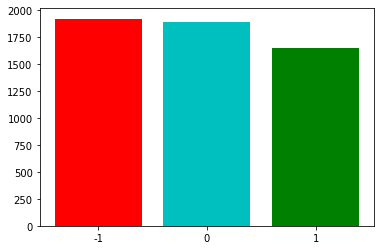

In [ ]:
plt.bar(height = obama_train_DA, x = ['-1', '0', '1'], color = ['r', 'c', 'g'])

In [ ]:
romney_train_DA = romney_train['Sentiment'].value_counts()
romney_train_DA

-1    2893
 0    1680
 1    1075
Name: Sentiment, dtype: int64

<BarContainer object of 3 artists>

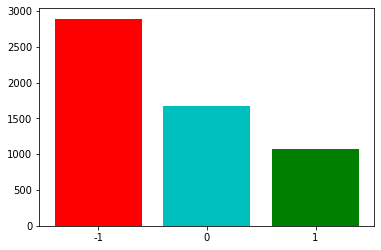

In [ ]:
plt.bar(height = romney_train_DA, x = ['-1', '0', '1'], color = ['r', 'c', 'g'])

# Romney data is very imbalanced
# So, its better to select the best model with respect to F1 Score

## Preprocessing the data

In [ ]:
# hm_lines = 5331

# tokenizer = nltk.RegexpTokenizer(r"\w+")
# spell = Speller(lang='en')
# # spell = SpellChecker()

# stop_words = set(stopwords.words('english'))
stop_list = stopwords.words('english')
stop_list.extend(['rt', 'retweet', 'e'])

lemmatizer = WordNetLemmatizer() 

In [ ]:
obama_train_pr, romney_train_pr = create_vocab(obama_train, romney_train)

In [ ]:
obama_train_pr.head()

,Doc Text,Sentiment
0,kirkpatrick wear baseball cap embroider obama ...,0
2,obama debate cracker as cracker tonight tune,1
4,miss point afraid understand big picture dont ...,0
6,raise democrat leave party year ago lifetime n...,-1
7,obama camp can not afford low expectation toni...,0


In [ ]:
obama_train_pr['Sentiment'] = obama_train_pr['Sentiment'].apply(lambda x: 'Positive' if x == 1 else ('Negative' if x == -1 else 'Neutral'))

In [ ]:
obama_train_pr.head()

,Doc Text,Sentiment
0,kirkpatrick wear baseball cap embroider obama ...,Neutral
2,obama debate cracker as cracker tonight tune,Positive
4,miss point afraid understand big picture dont ...,Neutral
6,raise democrat leave party year ago lifetime n...,Negative
7,obama camp can not afford low expectation toni...,Neutral


In [ ]:
obama_train_pr.iloc[10,:1]

Doc Text    obama priority k gaydar research security emba...
Name: 16, dtype: object

In [ ]:
romney_train_pr.head()

,Doc Text,Sentiment
0,insidious mitt romney bain help philip morris ...,-1
2,mean like romney cheat primary,-1
3,mitt romney still believe black president,-1
4,romney tax plan deserve nd look secret one dif...,-1
5,hope romney debate prepped people last time,1


In [ ]:
romney_train_pr['Sentiment'] = romney_train_pr['Sentiment'].apply(lambda x: 'Positive' if x == 1 else ('Negative' if x == -1 else 'Neutral'))

In [ ]:
romney_train_pr.head()

,Doc Text,Sentiment
0,insidious mitt romney bain help philip morris ...,Negative
2,mean like romney cheat primary,Negative
3,mitt romney still believe black president,Negative
4,romney tax plan deserve nd look secret one dif...,Negative
5,hope romney debate prepped people last time,Positive


In [ ]:
# obama_train_pr.to_csv(os.path.join(data_path, 'Obama Training1 Data.csv'))
# romney_train_pr.to_csv(os.path.join(data_path, 'Romney Training1 Data.csv'))

In [57]:
data_path = r'C:\Users\kalya\OneDrive - University of Illinois at Chicago\!UIC\!Semesters\3rd Sem\CS 583 Data Mining and Text Mining\Research Project\Data'

In [58]:
obama_train_pr_df = pd.read_csv(os.path.join(data_path, 'Obama Training1 Data.csv'), usecols = [1,2])
romney_train_pr_df = pd.read_csv(os.path.join(data_path, 'Romney Training1 Data.csv'), usecols = [1,2])

In [59]:
obama_train_pr_df.head()

,Doc Text,Sentiment
0,kirkpatrick wear baseball cap embroider obama ...,Neutral
1,obama debate cracker as cracker tonight tune t...,Positive
2,miss point afraid understand big picture dont ...,Neutral
3,raise democrat leave party year ago lifetime n...,Negative
4,obama camp can not afford low expectation toni...,Neutral


In [60]:
obama_train_pr_df = obama_train_pr_df.dropna()
romney_train_pr_df = romney_train_pr_df.dropna()

In [61]:
def one_hot(data):
    data = np.asarray(data)
    temp = np.zeros((len(data),3))
#     print(data[0])
    for i in range(len(temp)):
        if data[i] == 'Negative':
            temp[i][2] = 1 ## Negative sentiment third neuron
        elif data[i] == 'Neutral':
            temp[i][1] = 1 ## Neutral sentiment second neuron  
        else:
            temp[i][0] = 1 ## Positive sentiment first neuron 

    return temp
    
    


In [62]:
def pred(x):
    temp = []
    for i in x:
        m = np.argmax(i)
        if m == 0:
            temp.append('Positive')
        elif m == 1:
            temp.append('Neutral')
        else:
            temp.append('Negative')
    return temp

## Building Glove Dictionary

In [63]:
embeddings = {}
with open(os.path.join(data_path,"glove.twitter.27B.200d.txt"), 'r', encoding="utf-8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = asarray(values[1:], dtype='float32')
        embeddings[word] = vector

## Embedding Matrix Function

In [64]:
def emb_matrix(t,embeddings, we_dim):
    # creating a embedding matrix for the words in training data, which will be used as weight matrix for embedding layer
    vocab_size = len(t.word_index) + 1    
    embedding_matrix = zeros((vocab_size, we_dim))
    for word, i in t.word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, vocab_size

## Fine tuning the word embeddings of 300 dimensions using mittens library



## Used the code for finetuning from the following link:
### https://towardsdatascience.com/fine-tune-glove-embeddings-using-mittens-89b5f3fe4c39

In [65]:
def finetune(training): 
    training_tokens = [word_tokenize(i) for i in training['Doc Text']]
    #training_tokens

    oov = [j for i in training_tokens for j in i if j not in embeddings.keys()]
    print(len(oov))

    corp_vocab = list(set(oov))

    cv = CountVectorizer(ngram_range=(1,1), vocabulary=corp_vocab)
    trr =''
    for i in training_tokens:
        for j in i:
            trr+= j
            trr += ' '

    # print(trr)
    # print(z)
    X = cv.fit_transform([trr])
    Xc = (X.T * X)
    Xc.setdiag(0)
    coocc_ar = Xc.toarray()

    mittens_model = Mittens(n=200, max_iter=1000)

    new_embeddings = mittens_model.fit(
      coocc_ar,
      vocab=corp_vocab,
      initial_embedding_dict= embeddings)

    new_embeddings = dict(zip(corp_vocab, new_embeddings))
    return training_tokens, new_embeddings
  


In [66]:
embeddings2= embeddings.copy()

training_tokens, new_embeddings = finetune(obama_train_pr_df)
embeddings2.update(new_embeddings)

738


C:\Users\kalya\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
Iteration 1000: loss: 0.016246378421783447

In [67]:
oov2 = [j for i in training_tokens for j in i if j not in embeddings2.keys()]
print(len(oov2))

0


## Custom F1 value

In [68]:
def f1_value(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Building Vanilla RNN, LSTM, and GRU models

In [69]:
def model_vanilla_rnn(embedding_matrix, noh,  we_dim, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, we_dim, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(Bidirectional(SimpleRNN(units = noh, activation = activation, dropout=0.2, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef))))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=[f1_value])
#     print(model.summary())
    return model


In [70]:
def model_lstm(embedding_matrix, noh,  we_dim, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, we_dim, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(Bidirectional(LSTM(units = noh, activation = activation, dropout=0.2, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef))))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=[f1_value])
#     print(model.summary())
    return model


In [71]:
def model_gru(embedding_matrix, noh,  we_dim, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, we_dim, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(Bidirectional(GRU(units = noh, activation = activation, dropout=0.2, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef))))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=[f1_value])
#     print(model.summary())
    return model


In [46]:
obama_train2_pr_df, obama_val_pr_df = train_test_split(obama_train_pr_df, test_size = 0.2)

In [47]:
obama_train2_pr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4376 entries, 3018 to 939
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Doc Text   4376 non-null   object
 1   Sentiment  4376 non-null   object
dtypes: object(2)
memory usage: 102.6+ KB


In [36]:
obama_val_pr_df.info()

NameError: name 'obama_val_pr_df' is not defined

In [85]:
max_length = 20
epochs = 2
batch_size = 64
learning_rate = 0.001
we_dim = 200

tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(obama_train2_pr_df['Doc Text'])   
encoded_train = tokenise_tf.texts_to_sequences(obama_train2_pr_df['Doc Text'])
training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings2,we_dim)

encoded_validation = tokenise_tf.texts_to_sequences(obama_val_pr_df['Doc Text'])
validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')

adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
model = model_vanilla_rnn(embedding_matrix, 300, we_dim, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)
history = model.fit(training_padded, one_hot(obama_train2_pr_df['Sentiment']), epochs=epochs, verbose=2, batch_size=batch_size, shuffle =True)
y_pred_temp = model.predict(validation_padded)
y_pred = pred(y_pred_temp)
f1_list= np.round(f1_score(obama_val_pr_df['Sentiment'], y_pred, average = None),3)
accuracy = accuracy_score(obama_val_pr_df['Sentiment'], y_pred)
f1_dict = {'f1_pos': f1_list[2], 'f1_neu': f1_list[1], 'f1_neg': f1_list[0]}
# print([f1_list[2],f1_list[1],f1_list[0]])
print(f1_dict)
f1 = mean([accuracy, f1_list[2], f1_list[0]])


Train on 4376 samples
Epoch 1/2
4376/4376 - 6s - loss: 6.4114 - f1_value: 0.3803
Epoch 2/2
4376/4376 - 5s - loss: 3.8594 - f1_value: 0.4854
{'f1_pos': 0.551, 'f1_neu': 0.345, 'f1_neg': 0.634}


In [ ]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']
    em_dim = args['em_dim']

    
    encoded_train = tokenise_tf.texts_to_sequences(obama_train2_pr_df['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings2,we_dim)

    encoded_validation = tokenise_tf.texts_to_sequences(obama_val_pr_df['Doc Text'])
    validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')

    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_gru(embedding_matrix, em_dim, we_dim, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)
    history = model.fit(training_padded, one_hot(obama_train2_pr_df['Sentiment']), epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True)
    y_pred_temp = model.predict(validation_padded)
    y_pred = pred(y_pred_temp)
    f1_list= np.round(f1_score(obama_val_pr_df['Sentiment'], y_pred, average = None),3)
    accuracy = round(accuracy_score(obama_val_pr_df['Sentiment'], y_pred),3)
    eval_dict = {'accuracy': accuracy, 'f1_pos': f1_list[2], 'f1_neu': f1_list[1], 'f1_neg': f1_list[0]}
    # print([f1_list[2],f1_list[1],f1_list[0]])
    print('\n')
    print(eval_dict)
    f1 = mean([accuracy, f1_list[2], f1_list[0]])


    # loss, f1 = model.evaluate(validation_padded, one_hot(obama_val['Sentiment']))
#     f1 = history.history['f1_value'][-1]
   
    return - (f1)

space = {'max_length': hp.choice('max_length',range(4,60)),  
        'batch_size': hp.choice('batch_size', [32, 64, 128]),
         'epochs': hp.choice('epochs',range(5,30)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.1),
         'em_dim': hp.choice('em_dim', [50, 100, 200])
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(obama_train2_pr_df['Doc Text'])                                
best_gru = fmin(objective_func, space, algo=tpe.suggest, max_evals=15)
print(best_gru)

  0%|          | 0/15 [00:00<?, ?it/s, best loss: ?]WARNING:tensorflow:Layer gru_20 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
{'accuracy': 0.338, 'f1_pos': 0.101, 'f1_neu': 0.495, 'f1_neg': 0.0}
  7%|▋         | 1/15 [01:32<21:30, 92.15s/it, best loss: -0.14633333333333334]WARNING:tensorflow:Layer gru_21 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
{'accuracy': 0.551, 'f1_pos': 0.584, 'f1_neu': 0.533, 'f1_neg': 0.542}
 13%|█▎        | 2/15 [06:03<31:35, 145.84s/it, best loss: -0.559]             WARNING:tensorflow:Layer gru_22 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
{'accuracy': 0.565, 'f1_pos': 0.598, 'f1_neu': 0.505, 'f1_neg': 0.588}
 20%|██        | 3/15 [08:32<29:23, 146.93s/it, best loss: -0.5836666

## Building models for obama tweets

## Training the Model

## Using Hyperopt library to tune the Hyperparameters. 

### Cross Valid Function for LSTM

In [72]:
def cross_valid_lstm(X,y,epochs,batch_size,max_length, we_dim, learning_rate):
    f1_Positive  =[]
    f1_Neutral =[]
    f1_Negative =[]
    acc =[]
    cv = KFold(n_splits=5,shuffle=True)
    for train_index, val_index in cv.split(X):
    #     print("Train Index: ", train_index, "\n")
    #     print("Test Index: ", test_index)
    #     print(X.iloc[train_index])
    #     print(f)

        X_train1, X_val, y_train1, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
        tokenise_tf = Tokenizer()
        tokenise_tf.fit_on_texts(X_train1) 
    
        encoded_train = tokenise_tf.texts_to_sequences(X_train1)
        training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
        embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings2,we_dim)

        encoded_validation = tokenise_tf.texts_to_sequences(X_val)
        validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')
        adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
        model = model_lstm(embedding_matrix, 300, we_dim, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)        
        history = model.fit(training_padded, one_hot(y_train1), epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True)
        y_pred_temp = model.predict(validation_padded)
        y_pred = pred(y_pred_temp)

        f1_temp = f1_score(y_val, y_pred, average = None)

        f1_Positive.append(f1_temp[2])
        f1_Neutral.append(f1_temp[1])
        f1_Negative.append(f1_temp[0])

        acc.append(round(accuracy_score(y_val, y_pred),3))

    return round(mean(acc),3), round(mean(f1_Positive),3), round(mean(f1_Neutral),3), round(mean(f1_Negative),3)

### Cross Valid Function for GRU

In [73]:
def cross_valid_gru(X,y,epochs,batch_size,max_length, em_dim, we_dim, learning_rate):
    f1_Positive  =[]
    f1_Neutral =[]
    f1_Negative =[]
    acc =[]
    cv = KFold(n_splits=5,shuffle=True)
    for train_index, val_index in cv.split(X):
    #     print("Train Index: ", train_index, "\n")
    #     print("Test Index: ", test_index)
    #     print(X.iloc[train_index])
    #     print(f)

        X_train1, X_val, y_train1, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
        tokenise_tf = Tokenizer()
        tokenise_tf.fit_on_texts(X_train1) 
    
        encoded_train = tokenise_tf.texts_to_sequences(X_train1)
        training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
        embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings2,we_dim)

        encoded_validation = tokenise_tf.texts_to_sequences(X_val)
        validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')
        adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
        model = model_gru(embedding_matrix, em_dim, we_dim, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)        
        history = model.fit(training_padded, one_hot(y_train1), epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True)
        y_pred_temp = model.predict(validation_padded)
        y_pred = pred(y_pred_temp)

        f1_temp = f1_score(y_val, y_pred, average = None)

        f1_Positive.append(f1_temp[2])
        f1_Neutral.append(f1_temp[1])
        f1_Negative.append(f1_temp[0])

        acc.append(round(accuracy_score(y_val, y_pred),3))

    return round(mean(acc),3), round(mean(f1_Positive),3), round(mean(f1_Neutral),3), round(mean(f1_Negative),3)

In [74]:
# max_length = 8
# epochs = 1
# batch_size = 64
# learning_rate = 0.001
# we_dim = 200
# em_dim = 200

# # accuracy, f1_Positive, f1_Neutral, f1_Negative = cross_valid(obama_train_pr_df['Doc Text'],obama_train_pr_df['Sentiment'], epochs,batch_size,max_length, em_dim, we_dim, learning_rate)
# temp = cross_valid(obama_train_pr_df['Doc Text'],obama_train_pr_df['Sentiment'], epochs,batch_size,max_length, em_dim, we_dim, learning_rate)
# temp



In [75]:
# import warnings
# warnings.filterwarnings('ignore');

### Tuning Hyperparameters of GRU with Cross Valid GRU

In [ ]:
def objective_func_GRU(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']
    em_dim = args['em_dim']

    accuracy, f1_Positive, f1_Neutral, f1_Negative = cross_valid_gru(obama_train_pr_df['Doc Text'],obama_train_pr_df['Sentiment'], epochs,batch_size,max_length, em_dim, we_dim, learning_rate)
    f1 = round(mean([accuracy, f1_Positive, f1_Negative]),3)    
    eval_dict = {'accuracy': accuracy, 'f1_pos': f1_Positive, 'f1_neu': f1_Neutral, 'f1_neg': f1_Negative, 'f1_eval': f1}
    print('\n')
    print(eval_dict)

    return -(f1)

space = {'max_length': hp.choice('max_length',range(4,60)),  
        'batch_size': hp.choice('batch_size', [32, 64, 128]),
         'epochs': hp.choice('epochs',range(5,30)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.1),
         'em_dim': hp.choice('em_dim', [50, 100, 200])
        }                     
                                
we_dim = 200                               
best_GRU_cv = fmin(objective_func_GRU, space, algo=tpe.suggest, max_evals=20)
print(best_GRU_cv)

{'accuracy': 0.425, 'f1_pos': 0.367, 'f1_neu': 0.311, 'f1_neg': 0.403, 'f1_eval': 0.398}
{'accuracy': 0.575, 'f1_pos': 0.59, 'f1_neu': 0.493, 'f1_neg': 0.621, 'f1_eval': 0.595}
{'accuracy': 0.516, 'f1_pos': 0.522, 'f1_neu': 0.448, 'f1_neg': 0.565, 'f1_eval': 0.534}
{'accuracy': 0.555, 'f1_pos': 0.566, 'f1_neu': 0.514, 'f1_neg': 0.577, 'f1_eval': 0.566}
{'accuracy': 0.474, 'f1_pos': 0.419, 'f1_neu': 0.398, 'f1_neg': 0.471, 'f1_eval': 0.455}
{'accuracy': 0.477, 'f1_pos': 0.413, 'f1_neu': 0.366, 'f1_neg': 0.52, 'f1_eval': 0.47}
 30%|███       | 6/20 [7:12:29<26:21:45, 6779.00s/trial, best loss: -0.595]

### Tuning Hyperparameters of LSTM with Cross Valid LSTM

In [ ]:
def objective_func_LSTM(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']
    em_dim = args['em_dim']

    accuracy, f1_Positive, f1_Neutral, f1_Negative = cross_valid_lstm(obama_train_pr_df['Doc Text'],obama_train_pr_df['Sentiment'], epochs,batch_size,max_length, em_dim, we_dim, learning_rate)
    f1 = round(mean([accuracy, f1_Positive, f1_Negative]),3)    
    eval_dict = {'accuracy': accuracy, 'f1_pos': f1_Positive, 'f1_neu': f1_Neutral, 'f1_neg': f1_Negative, 'f1_eval': f1}
    print('\n')
    print(eval_dict)

    return -(f1)

space = {'max_length': hp.choice('max_length',range(4,60)),  
        'batch_size': hp.choice('batch_size', [32, 64, 128]),
         'epochs': hp.choice('epochs',range(5,30)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.1),
         'em_dim': hp.choice('em_dim', [50, 100, 200])
        }                       
                                
we_dim = 200                                
best_LSTM_cv = fmin(objective_func_LSTM, space, algo=tpe.suggest, max_evals=20)
print(best_LSTM_cv)

In [ ]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(obama_train['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings2)

    encoded_validation = tokenise_tf.texts_to_sequences(obama_val['Doc Text'])
    validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')

    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_vanilla_rnn(embedding_matrix, 300, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, one_hot(obama_train['Sentiment']), epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True)
    y_pred_temp = model.predict(validation_padded)
    y_pred = pred(y_pred_temp)
    f1= f1_score(obama_val['Sentiment'], y_pred, average = 'macro')
    # loss, f1 = model.evaluate(validation_padded, one_hot(obama_val['Sentiment']))
#     f1 = history.history['f1_value'][-1]
   
    return -round(f1,2)

space = {'max_length': hp.choice('max_length',range(4,20)),  
        'batch_size': hp.choice('batch_size', [32, 64, 128]),
         'epochs': hp.choice('epochs',range(10,30)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(obama_train['Doc Text'])                                
best_vanilla_rnn = fmin(objective_func, space, algo=tpe.suggest, max_evals=20)
print(best_vanilla_rnn)

100%|██████████| 20/20 [29:00<00:00, 87.03s/it, best loss: -0.55] 
{'batch_size': 1, 'epochs': 1, 'learning_rate': 0.0018559993912219612, 'max_length': 3}


In [ ]:
max_length = 5
epochs = 5
batch_size = 64
learning_rate = 0.0007711038235329859

tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(obama_train['Doc Text'])   
encoded_train = tokenise_tf.texts_to_sequences(obama_train['Doc Text'])
training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings2)

encoded_validation = tokenise_tf.texts_to_sequences(obama_val['Doc Text'])
validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')

adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
model = model_vanilla_rnn(embedding_matrix, 300, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

history = model.fit(training_padded, one_hot(obama_train['Sentiment']), epochs=epochs, verbose=1, batch_size=batch_size, shuffle =True)
y_pred_temp = model.predict(validation_padded)
y_pred = pred(y_pred_temp)
acc= accuracy_score(obama_val['Sentiment'], y_pred)
print(acc)




Train on 4376 samples
Epoch 1/5
4376/4376 [==============================] - 2s 431us/sample - loss: 8.9841
Epoch 2/5
4376/4376 [==============================] - 2s 418us/sample - loss: 6.2251
Epoch 3/5
4376/4376 [==============================] - 2s 417us/sample - loss: 4.1734
Epoch 4/5
4376/4376 [==============================] - 2s 424us/sample - loss: 2.7909
Epoch 5/5
4376/4376 [==============================] - 2s 428us/sample - loss: 2.0136
0.49177330895795246


# For LSTM rnn, the best hyper parameters are:
# 'batch_size': 128, 'epochs': 10, 'learning_rate': 0.002, 'max_length': 50

# For GRU rnn, the best hyper parameters are:
# 'batch_size': 64, 'epochs': 7, 'learning_rate': 0.0006, 'max_length': 11